# Aerial images road segmentation with a Unet
by Braz Lucas, Durand Pierre-Alain and Nicolle Clement


### Importing librairies

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm, trange
import glob
import os
import sys
from PIL import Image
from scipy import ndimage

### Visualisation function

In [2]:
def imshow(img, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(7,7))
    if len(img.shape) == 3:
        fig = ax.imshow(np.moveaxis(img, 0, -1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    else:
        fig = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def imshow_overlay(img_to_show):
    img_to_show = (img_to_show,) if isinstance(img_to_show,int) else img_to_show
    upscale = nn.Upsample(scale_factor=608/400, mode='bilinear', align_corners=True).to(device)
    fig, ax = plt.subplots(len(img_to_show)//2+len(img_to_show)%2,2,figsize=(15,8*(len(img_to_show)//2+len(img_to_show)%2)))
    ax = ax.flatten()
    for idx, img in enumerate(img_to_show):
        img_real = upscale(dataset_test[img][None])[0].cpu().detach().numpy()
        img_real = np.moveaxis(img_real, 0, -1)
        img_to_print = make_img_overlay(img_real,imgs[img])
        fig = ax[idx].imshow(img_to_print)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    if len(img_to_show)%2 != 0:
        ax[len(img_to_show)].get_xaxis().set_visible(False)
        ax[len(img_to_show)].get_yaxis().set_visible(False)

In [3]:
def rotate45(img):
    img = ndimage.rotate(img,45)
    cropx = 272
    cropy = 272
    if img.ndim == 3:
        y,x,_ = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        img = img[starty:starty+cropy,startx:startx+cropx,:]
    else:
        y,x = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)
        img = img[starty:starty+cropy,startx:startx+cropx]
    return img

### Import and pre processing of data

In [4]:
dataset_train = [np.moveaxis(mpimg.imread(f"training/images/satImage_{i:03}.png"), -1, 0) for i in range(1,101)]
# dataset_train += [np.moveaxis(np.transpose(mpimg.imread(f"training/images/satImage_{i:03}.png"),(1,0,2)), -1, 0) for i in range(1,101)]
dataset_train += [np.moveaxis(rotate45(mpimg.imread(f"training/images/satImage_{i:03}.png")), -1, 0) for i in range(1,101)]

labels_train = [mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8) for i in range(1,101)]
# labels_train += [np.transpose(mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8),(1,0)) for i in range(1,101)]
labels_train += [rotate45(mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.uint8)) for i in range(1,101)]

dataset_test = np.array([resize(mpimg.imread(f"test_set_images/test_{i}/test_{i}.png"),(400,400,3)) for i in range(1,51)])
dataset_test = np.moveaxis(dataset_test, -1, 1)

In [5]:
print(f"len(dataset_train) : {len(dataset_train)}")
print(f"len(labels_train) : {len(labels_train)}")
print(f"dataset_train[0].shape : {dataset_train[0].shape}")
print(f"dataset_train[-1].shape : {dataset_train[-1].shape}")
print(f"labels[0].shape : {labels_train[0].shape}")
print(f"labels[-1].shape : {labels_train[-1].shape}")
print(f"dataset_test.shape : {dataset_test.shape}")

len(dataset_train) : 200
len(labels_train) : 200
dataset_train[0].shape : (3, 400, 400)
dataset_train[-1].shape : (3, 272, 272)
labels[0].shape : (400, 400)
labels[-1].shape : (272, 272)
dataset_test.shape : (50, 3, 400, 400)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


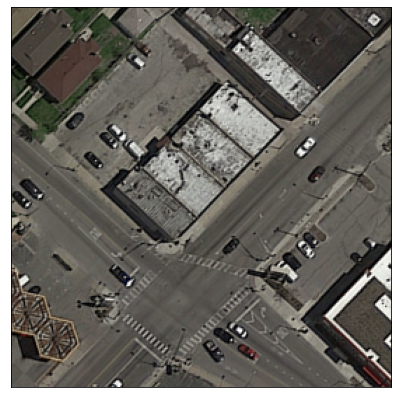

In [6]:
imshow(dataset_train[-1])

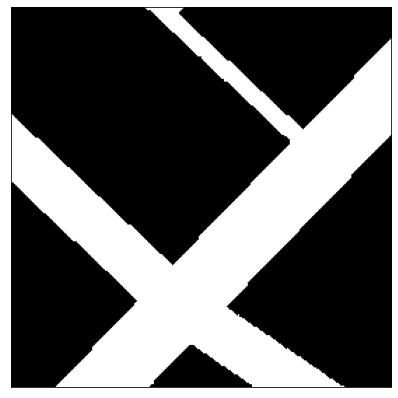

In [7]:
imshow(labels_train[-1]);

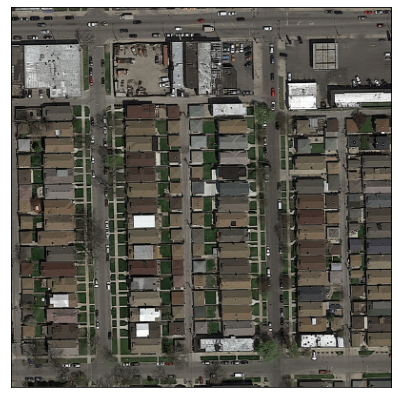

In [8]:
imshow(dataset_test[0]);

In [9]:
random_seed = 0

train_size = 0.9  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    dataset_train,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    labels_train,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

In [10]:
inputs_train = [torch.Tensor(img) for img in inputs_train]
inputs_valid = [torch.Tensor(img) for img in inputs_valid]
targets_train = [torch.Tensor(img).type(torch.LongTensor) for img in targets_train]
targets_valid = [torch.Tensor(img).type(torch.LongTensor) for img in targets_valid]

In [11]:
dataset_test = torch.from_numpy(dataset_test)

In [12]:
print(f"inputs_train.dtype : {inputs_train[0].dtype}")
print(f"inputs_valid.dtype : {inputs_valid[0].dtype}")
print(f"targets_train.dtype : {targets_train[0].dtype}")
print(f"targets_valid.dtype : {targets_valid[0].dtype}")

inputs_train.dtype : torch.float32
inputs_valid.dtype : torch.float32
targets_train.dtype : torch.int64
targets_valid.dtype : torch.int64


### Creation of the MODEL UNET

In [13]:
# class Unet(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.downblock1 = nn.Sequential(
#             # nn.Dropout2d(0.2),
#             nn.Conv2d(3, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
#         self.downblock2 = nn.Sequential(
#             nn.MaxPool2d(kernel_size=2),
#             # nn.Dropout2d(0.2),
#             nn.Conv2d(64, 128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True)
#         )
#         self.downblock3 = nn.Sequential(
#             nn.MaxPool2d(kernel_size=2),
#             # nn.Dropout2d(0.2),          
#             nn.Conv2d(128, 256, kernel_size=3),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True)
#         )
#         self.downblock4 = nn.Sequential(
#             nn.MaxPool2d(kernel_size=2),
#             # nn.Dropout2d(0.2),
#             nn.Conv2d(256, 512, kernel_size=3),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True)
#         )
#         self.middleU = nn.Sequential(
#             nn.MaxPool2d(kernel_size=2),
#             # nn.Dropout2d(0.2),
#             nn.Conv2d(512, 1024, kernel_size=3),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(1024, 1024, kernel_size=3),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(inplace=True),
#             # nn.Dropout2d(0.2),
#             nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         )

#         self.upblock1 = nn.Sequential(
#             nn.Conv2d(1024, 512, kernel_size=3),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             # nn.Dropout2d(0.2),
#             nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         )

#         self.upblock2 = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=3),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             # nn.Dropout2d(0.2),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         )

#         self.upblock3 = nn.Sequential(
#             nn.Conv2d(256, 128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             # nn.Dropout2d(0.2),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         )

#         self.upblock4 = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 2, kernel_size=1)
#         )
    

#     def forward(self, x):
#         x1 = self.downblock1(x)

#         x2 = self.downblock2(x1)

#         x3 = self.downblock3(x2)

#         x4 = self.downblock4(x3)

#         xmiddle = self.middleU(x4)

#         x4cut = x4[:,:,4:-4,4:-4]
#         xup0_1 = torch.cat((x4cut,xmiddle), dim=1)
#         xup1 = self.upblock1(xup0_1)

#         x3cut = x3[:,:,16:-17,16:-17]
#         xup1_2 = torch.cat((x3cut,xup1), dim=1)
#         xup2 = self.upblock2(xup1_2)

#         x2cut = x2[:,:,41:-41,41:-41]
#         xup2_3 = torch.cat((x2cut,xup2), dim=1)
#         xup3 = self.upblock3(xup2_3)
        
#         x1cut = x1[:,:,90:-90,90:-90]
#         xup3_4 = torch.cat((x1cut,xup3), dim=1)
#         xup4 = self.upblock4(xup3_4)

#         adaptsize = nn.Upsample(x.shape[2])#, mode='bilinear', align_corners=True)

#         xfinal = adaptsize(xup4)

#         return xfinal

In [14]:
class Unet(nn.Module):

    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(3, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),          
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.downblock4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        )

        self.upblock4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1)
        )
    

    def forward(self, x):
        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        x4 = self.downblock4(x3)


        xmiddle = self.middleU(x4)


        xup0_1 = torch.cat((x4,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x3,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x2,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        xup3_4 = torch.cat((x1,xup3), dim=1)
        xup4 = self.upblock4(xup3_4)

        return xup4

### Creation of the criterion and functions for training and validation

In [22]:
def train_epoch(data_loader, model, optimiser, device, criterion):

  # set model to training mode. This is important because some layers behave differently during training and testing
  model.train(True)
  model.to(device)

  # stats
  loss_total = 0.0
  f1_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):

    # put data and target onto correct device
    data, target = data.to(device), target.to(device)

    # reset gradients
    optimiser.zero_grad()

    # forward pass
    pred = model(data)

    # loss
    loss = criterion(pred, target)

    # backward pass
    loss.backward()

    # parameter update
    optimiser.step()

    # stats update
    loss_total += loss.item()
    f1_total += f1_score(target.cpu().detach().numpy().flatten(), pred.argmax(1).cpu().detach().numpy().flatten())
    oa_total += torch.mean((pred.argmax(1) == target).float()).item()

    # format progress bar
    pBar.set_description('Loss: {:.2f}, F1: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * f1_total/(idx+1),
      100 * oa_total/(idx+1)
    ))
    pBar.update(1)
  
  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  f1_total /= len(data_loader)
  oa_total /= len(data_loader)

  return model, loss_total, f1_total, oa_total

In [16]:
def validate_epoch(data_loader, model, device, criterion):

  # set model to evaluation mode
  model.train(False)
  model.to(device)

  # stats
  loss_total = 0.0
  f1_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):
    with torch.no_grad():

      # put data and target onto correct device
      data, target = data.to(device), target.to(device)

      # forward pass
      pred = model(data)

      # loss
      loss = criterion(pred, target)

      # stats update
      loss_total += loss.item()
      f1_total += f1_score(target.cpu().detach().numpy().flatten(), pred.argmax(1).cpu().detach().numpy().flatten())
      oa_total += torch.mean((pred.argmax(1) == target).float()).item()

      # format progress bar
      pBar.set_description('Loss: {:.2f}, F1: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * f1_total/(idx+1),
      100 * oa_total/(idx+1)
      ))
      pBar.update(1)

  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  f1_total /= len(data_loader)
  oa_total /= len(data_loader)

  return loss_total, f1_total, oa_total

In [17]:
class Jaccard(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(Jaccard, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

### Function to load and save the model

In [18]:
os.makedirs('unet_states/Unet', exist_ok=True)

def load_model(epoch='latest'):
  model = Unet()
  modelStates = glob.glob('unet_states/Unet/*.pth')
  if len(modelStates) and (epoch == 'latest' or epoch > 0):
    modelStates = [int(m[17:-4]) for m in modelStates]
    if epoch == 'latest':
      epoch = max(modelStates)
    stateDict = torch.load(open(f'unet_states/Unet/{epoch}.pth', 'rb'), map_location='cpu')
    model.load_state_dict(stateDict)
  else:
    # fresh model
    epoch = 0
  return model, epoch


def save_model(model, epoch, stroutput):
  torch.save(model.state_dict(), open(f'unet_states/Unet/{epoch}.pth', 'wb'))
  with open(f'unet_states/Unet/{epoch}.txt', 'w') as file:  # Use file to refer to the file object
    file.write(stroutput)

### launch

In [26]:
# If a GPU is available (should be on Colab, we will use it)
if not torch.cuda.is_available():
  raise Exception("Things will go much quicker if you enable a GPU in Colab under 'Runtime / Change Runtime Type'")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_test = dataset_test.to(device)
# batch 1
dataset_training = [[inputs_train[i][None].to(device), targets_train[i][None].to(device)] for i in range(len(inputs_train))]
dataset_valid = [[inputs_valid[i][None].to(device), targets_valid[i][None].to(device)] for i in range(len(inputs_valid))]

start_epoch = 0 # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
# load model
model, epoch = load_model(epoch=start_epoch)

# optimizer
learning_rate = 0.01
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optim, gamma=0.95)
min_loss = torch.tensor(float('inf'))
scheduler_counter = 0

# criterion
criterion = nn.CrossEntropyLoss().to(device)
# criterion = Jaccard().to(device)

In [27]:
num_epochs = epoch+30

# do epochs
while epoch < num_epochs:

  # training
  model, loss_train, f1_train, oa_train = train_epoch(dataset_training, model, optim, device, criterion)

  # validation
  loss_val, f1_val, oa_val = validate_epoch(dataset_valid, model, device, criterion)

  # print stats
  stroutput = f"[Ep. {epoch+1}/{num_epochs}] Loss train: {loss_train:.2f}, Loss val: {loss_val:.2f}; F1 train: {100*f1_train:.2f}, F1 val: {100*f1_val:.2f}; OA train: {100*oa_train:.2f}, OA val: {100*oa_val:.2f}"
  print(stroutput)

# for LR scheduler
  scheduler_counter+=1
  is_best = loss_val < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(loss_val, min_loss)
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    scheduler_counter = 0
  # end for LR scheduler

  # save model
  epoch += 1
  save_model(model, epoch, stroutput)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 1/30] Loss train: 0.43, Loss val: 0.37; F1 train: 27.27, F1 val: 56.20; OA train: 81.31, OA val: 83.30


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 2/30] Loss train: 0.35, Loss val: 0.33; F1 train: 48.42, F1 val: 68.16; OA train: 84.12, OA val: 85.58


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 3/30] Loss train: 0.31, Loss val: 0.27; F1 train: 60.77, F1 val: 71.76; OA train: 86.89, OA val: 88.39


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 4/30] Loss train: 0.27, Loss val: 0.31; F1 train: 66.59, F1 val: 60.05; OA train: 88.66, OA val: 86.78


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 5/30] Loss train: 0.23, Loss val: 0.21; F1 train: 71.89, F1 val: 78.49; OA train: 90.47, OA val: 91.07


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 6/30] Loss train: 0.20, Loss val: 0.21; F1 train: 75.99, F1 val: 79.35; OA train: 91.88, OA val: 91.40


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 7/30] Loss train: 0.17, Loss val: 0.22; F1 train: 79.02, F1 val: 77.49; OA train: 93.00, OA val: 91.10


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 8/30] Loss train: 0.15, Loss val: 0.22; F1 train: 81.37, F1 val: 77.11; OA train: 93.88, OA val: 91.37


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 9/30] Loss train: 0.13, Loss val: 0.22; F1 train: 83.61, F1 val: 78.93; OA train: 94.75, OA val: 92.06


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 10/30] Loss train: 0.12, Loss val: 0.19; F1 train: 85.09, F1 val: 81.14; OA train: 95.33, OA val: 92.58


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 11/30] Loss train: 0.10, Loss val: 0.19; F1 train: 87.64, F1 val: 82.43; OA train: 96.19, OA val: 92.56


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 12/30] Loss train: 0.08, Loss val: 0.20; F1 train: 88.87, F1 val: 82.13; OA train: 96.67, OA val: 91.54


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 13/30] Loss train: 0.08, Loss val: 0.18; F1 train: 89.83, F1 val: 84.15; OA train: 96.95, OA val: 93.19


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 14/30] Loss train: 0.06, Loss val: 0.19; F1 train: 91.19, F1 val: 83.84; OA train: 97.42, OA val: 92.84


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 15/30] Loss train: 0.06, Loss val: 0.20; F1 train: 91.71, F1 val: 82.87; OA train: 97.60, OA val: 92.63


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[Ep. 16/30] Loss train: 0.06, Loss val: 0.21; F1 train: 92.39, F1 val: 82.92; OA train: 97.71, OA val: 92.50


  0%|          | 0/180 [00:00<?, ?it/s]

### Verify results visually

In [ ]:
def imshow_overlay_training(img_to_show):
    img_to_show = (img_to_show,) if isinstance(img_to_show,int) else img_to_show
    fig, ax = plt.subplots(len(img_to_show),2,figsize=(15,8*len(img_to_show)))
    ax = ax.flatten()
    for idx, img in enumerate(img_to_show):
        img_real = dataset_valid[img][0][0].cpu().detach().numpy()
        img_real = np.moveaxis(img_real, 0, -1)
        img_target = dataset_valid[img][1][0].cpu().detach().numpy()
        img_to_print = make_img_overlay(img_real,img_target)
        fig = ax[2*idx].imshow(img_to_print)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        ax[2*idx].set_title(f"Image {img} : target")

        img_pred = model(dataset_valid[img][0])[0].argmax(0).cpu().detach().numpy()
        img_to_print = make_img_overlay(img_real,img_pred)
        fig = ax[2*idx+1].imshow(img_to_print)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        ax[2*idx+1].set_title(f"Image {img} : prediction")

In [ ]:
imshow_overlay_training((9,7))

### Verify results for testset and create a submission

In [ ]:
dataset_test = dataset_test.to(device)
imgs = []
for img in dataset_test:
  output = model.forward(img[None])
  yhat2 = output.argmax(dim=1).to(torch.float32)[None]
  upscale = nn.Upsample(scale_factor=608/400, mode='bilinear', align_corners=True).to(device)
  yhat2 = upscale(yhat2)
  yhat2 = yhat2[0,0].cpu().detach().numpy()
  imgs.append(yhat2)
print(len(imgs))
print(imgs[0].shape)

In [ ]:
img_to_show = (2,4, 6,8)
imshow_overlay(img_to_show)

In [ ]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(nb, imgs):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = imgs[nb]
    img_number = nb+1
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, imgs):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(len(imgs)):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(i,imgs))

In [ ]:
number_submission = 12

In [ ]:
submission_filename = f'submission/submission_{number_submission}_BRAZ_DURAND_NICOLLE.csv'
masks_to_submission(submission_filename, imgs)
number_submission+=1

     _____________________________________________________________________________________________________________________________